In [1]:
%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt

## Toolkit Libraries

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Simulation Parameters

In [3]:
# System Parameters
center_frequency    = 1000e6 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)

## PBCH Payload Generation: MIB + ATI

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = 20        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP*(fftSize/tfParams.Nfft)).astype(np.int32)    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


## PSS, SSS, PBCH, DMRS Generation

In [5]:
N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2)
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Constellation Diagram: Tx

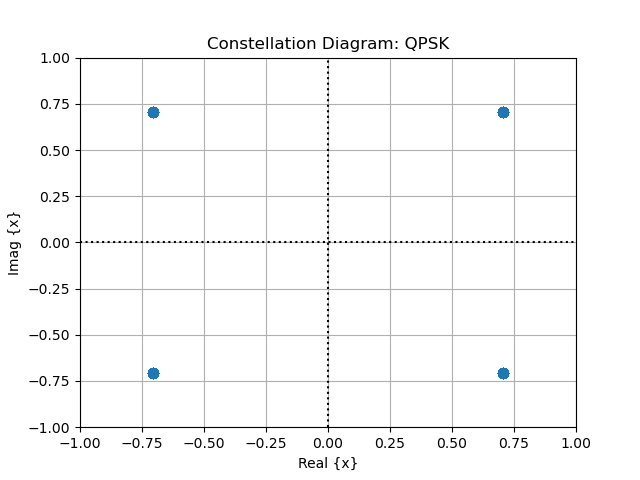

In [6]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

## SSB Generation

In [7]:

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, N_RB=nRB,
                              kssb=0, offsetToPointA = int(nRB*0.5-10),
                              scsCarrier = subCarrierSpacingCommon,
                              ssbPositionInBurst = ssbPositionInBurst, ssbPeriodicity = None, nHF=None,
                              nFrames = 0.1*(subcarrier_spacing/subCarrierSpacingCommon), isPairedBand = isPairedBand,
                              withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid     = ssbRGobject(ssb[1])

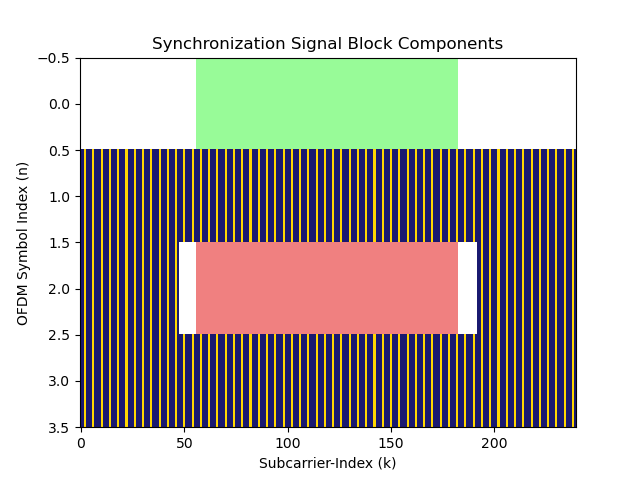

In [8]:
fig = ssbObject.displayGrid(option=1)

## OFDM Implementation

In [9]:
x = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.reshape(
    tf.convert_to_tensor(ssbGrid, dtype=tf.complex64),[-1]), axis=0), axis=0), axis=0)
#______________________________________________________

## Loading Resource Grid to Transmission Grid
#####################################
nSymbolsForSimulation = ssbRGobject.numSymbols
txGridObj = sn.ofdm.ResourceGrid(num_ofdm_symbols = numOFDMSymbols,
                                 fft_size = fftSize,
                                 subcarrier_spacing = subcarrier_spacing,
                                 num_tx = 1,
                                 num_streams_per_tx   = 1,
                                 cyclic_prefix_length = lengthCP[1],
                                 num_guard_carriers   = (int((fftSize-Neff)/2), int((fftSize-Neff)/2)),
                                 dc_null = False,
                                 pilot_pattern = None,
                                 pilot_ofdm_symbol_indices = None,
                                 dtype = tf.complex64)


txGrid = sn.ofdm.ResourceGridMapper(txGridObj);
X      = txGrid(x)
#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(txGridObj.cyclic_prefix_length)
x_time    = modulator(X).flatten()
#______________________________________________________

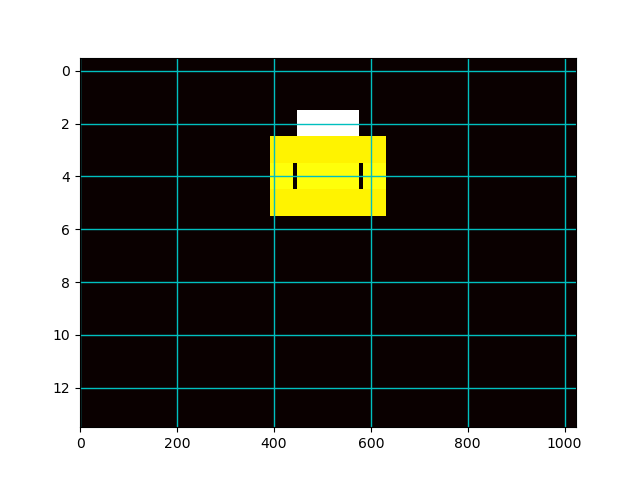

In [10]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X[0][0][0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
# Gridlines based on minor ticks
plt.show()

## SDR Setup

In [11]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -0 # Increase to increase tx power, valid range is -90 to 0 dB

## Transmission

In [12]:
np.max(np.abs((1.2*2**17*x_time)))

13152.274900499282

In [13]:
sdr.tx_destroy_buffer()

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers

# while(True):
sdr.tx(1.2*2**17*(x_time.repeat(1))) # start transmitting

# # # Stop transmitting
# sdr.tx_destroy_buffer()



## Verification

In [14]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeB
controlResourceSet0:	4
searchSpace0: 		11
cellBarred: 		notBarred
intraFreqReselection: 	allowed
systemFrameNumber: 	454
ssbSubCarrierOffset: 	17
HRFBit: 		1
iSSBindex: 		0


In [15]:
lengthCP[0], N_ID1, N_ID2, ssbIndex[1], hrfBit, nssbCandidatesInHrf

(88, 62, 0, 1, 1, 10)